# Optimal design of a fluid tank

## Introduction

This tutorial demonstrates how simulations performed via Inductiva API can be used in an optimal design task.

In a previous notebook, we have demonstrated how Inductiva API can be used to perform design space exploration with a low-level call of a simulator. Here, we explain how the same can be done for a specific scenario and how to post-process simulation data to determine optimal design conditions.

We make use of a pre-built simulation scenario of a fluid tank, i.e. a fluid container with an inlet-outlet system responsible for renovating the fluid. This scenario is schematically represented in the diagram below.

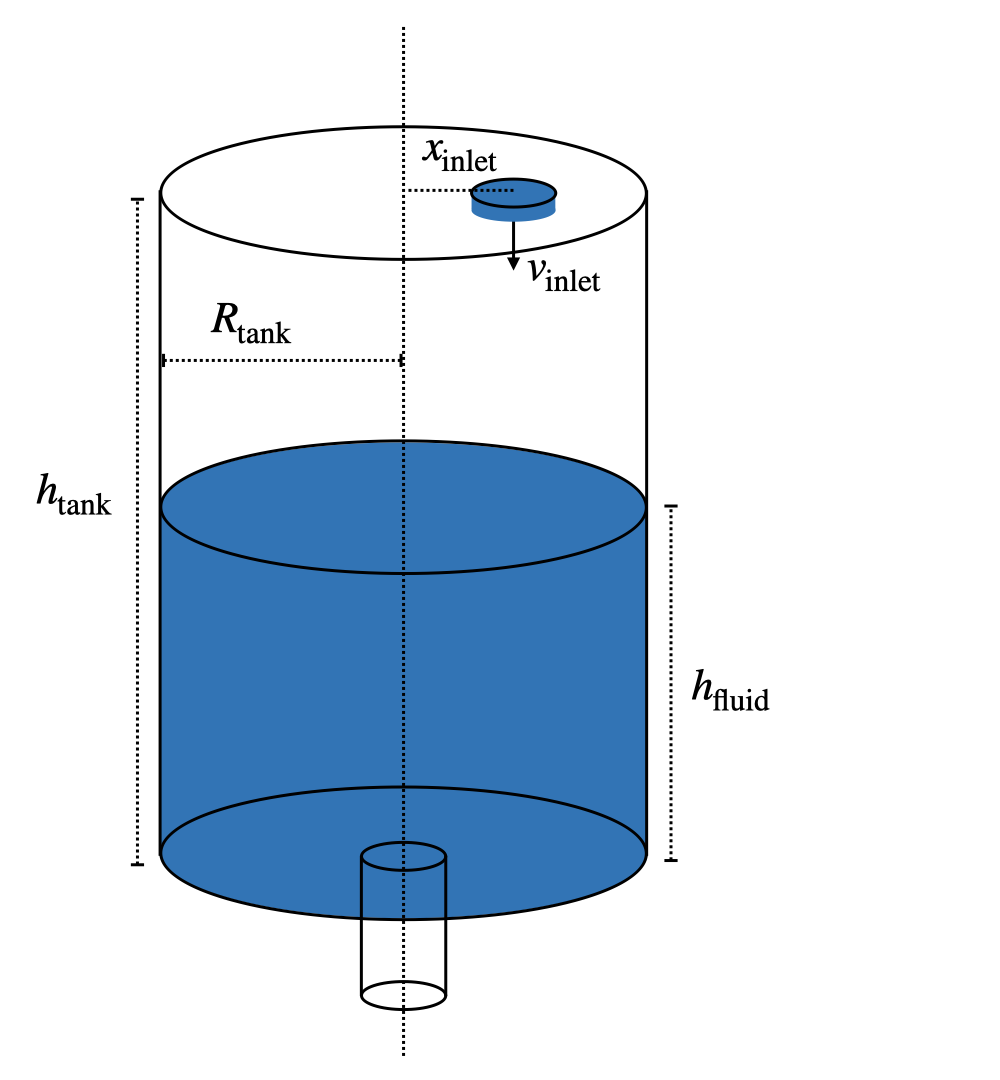

The fluid tank is a cylinder of radius $R_\mathrm{tank}$ and height $h_\mathrm{tank}$, initially filled with a height $h_\mathrm{fluid}$ of fluid. New fluid is injected with velocity $v_\mathrm{inlet}$ into the tank from a circular inlet at the top of the container with arbitrary coordinates $(x_\mathrm{inlet}, y_\mathrm{inlet})$. The fluid exits the tank from a cylindrical outlet at the bottom of the container.

In this tutorial, we perform simulations of this scenario varying a single parameter, in order to demonstrate the impact of design parameters in a metric of interest.

More specifically, we vary $x_\mathrm{inlet}$ and show that it has an important impact on the average fluid velocity inside the tank. We thus illustrate that Inductiva API can be used for streamlined experimentation with simulations, including in optimization pipelines.

## Setup

We start by installing and importing the Inductiva API package. We also import other packages required for this tutorial.

Note that a personal key is required to use the Inductiva API. You can obtain one by completing [this form](https://forms.gle/MkcvWA8BuUFmGVVu6).

In [ ]:
# Install the Inductiva API package.
!pip install inductiva

In [2]:
# Import Inductiva API package.
import inductiva

# Import also other packages needed for this tutorial.
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# Set the API key to be able to access our hardware.
# inductiva.api_key = "ADD_KEY_HERE"

## Simulate

Next, we use Inductiva API to perform simulations of the scenario described above with varying $x_\mathrm{inlet}$. We consider $x_\mathrm{inlet} \in \{0, 0.1, 0.2, 0.3\}$ m. The case $x_\mathrm{inlet} = 0$ m corresponds to an inlet centered with the main axis of the tank (and thus with the outlet), whereas the case $x_\mathrm{inlet} = 0.3$ m is the case of maximum inlet-outlet misalignment.

Simulations are performed in Inductiva servers, i.e. local access to performant hardware like expensive GPUs or large CPU nodes and to simulator binaries is not required.

In [4]:
inlet_xs = [0, 0.1, 0.2, 0.3]

for inlet_x in inlet_xs:
    tank = inductiva.fluids.scenarios.FluidTank(
        fluid=inductiva.fluids.WATER,
        fluid_level=0.5,
        inlet=inductiva.fluids.scenarios.CircularTankInlet(radius=0.1, fluid_velocity=1.5, position=[inlet_x, 0]),
    )
    
    tank.simulate(output_dir=f"inlet_xs/{inlet_x}")

INFO:absl:Uploading input files...
INFO:absl:Request submitted.
INFO:absl:An executer has picked up the request.
INFO:absl:The requested task is being executed remotely...
INFO:absl:Task executed successfuly.
INFO:absl:Downloading output...
INFO:absl:Output downloaded.
INFO:absl:Extracting output ZIP file to "/content/inlet_xs/0"...
INFO:absl:Output extracted.
INFO:absl:Converting vtk files to netcdf format...
100%|██████████| 51/51 [00:01<00:00, 43.11it/s]
INFO:absl:Uploading input files...
INFO:absl:Request submitted.
INFO:absl:An executer has picked up the request.
INFO:absl:The requested task is being executed remotely...
INFO:absl:Task executed successfuly.
INFO:absl:Downloading output...
INFO:absl:Output downloaded.
INFO:absl:Extracting output ZIP file to "/content/inlet_xs/0.1"...
INFO:absl:Output extracted.
INFO:absl:Converting vtk files to netcdf format...
100%|██████████| 51/51 [00:00<00:00, 95.07it/s]
INFO:absl:Uploading input files...
INFO:absl:Request submitted.
INFO:absl:

## Post-process simulation data

The simulation data is saved in the sub-directories of `inlet_xs`.

We now:
1. Read it to memory, using the handy package [xarray](https://docs.xarray.dev/en/stable/).
2. Process it to compute the average fluid velocity in the tank.
3. Plot the results, using the well-known package [matplotlib](https://matplotlib.org/).

In [5]:
# Read output data of all simulations.
particle_data = {inlet_x: xr.open_mfdataset(f"inlet_xs/{inlet_x}/netcdf/*.nc") for inlet_x in inlet_xs}

In [6]:
def get_avg_fluid_velocity(particle_data):
    """Estimates the average fluid velocity inside the tank."""

    # Compute velocity magnitude.
    fluid_velocity = np.sqrt(particle_data["velocity_x"]**2 + 
                             particle_data["velocity_y"]**2 + 
                             particle_data["velocity_z"]**2)
    
    # Average over particles.
    avg_fluid_velocity = fluid_velocity.mean(dim="particle_idx")

    # Set data attributes.
    avg_fluid_velocity.attrs.update({
        "long_name": "avg. fluid velocity",
        "units": "m/s"
    })

    return avg_fluid_velocity

# Estimate average velocity inside the tank for each simulations.
avg_fluid_velocity = {inlet_x: get_avg_fluid_velocity(particle_data[inlet_x]) for inlet_x in inlet_xs}

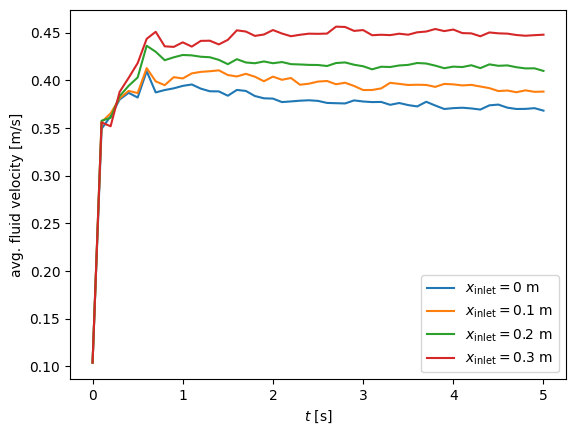

In [7]:
# Plot average velocity as a function of time.
for inlet_x in inlet_xs:
    avg_fluid_velocity[inlet_x].plot(label=f"$x_\mathrm{{inlet}} = {inlet_x}$ m")
plt.legend()
plt.show()

The results show that the average fluid velocity increases with $x_\mathrm{inlet}$, i.e. with the inlet-outlet displacement.

This increase simply due to geometrical factors is illustrative of the relevance of simulation in optimal design of fluid tanks.

In this case, as in others, Inductiva API effectively streamlines the process of experimentation and design parameter space exploration.